In [297]:
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 10
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
        ax.set_title(label)

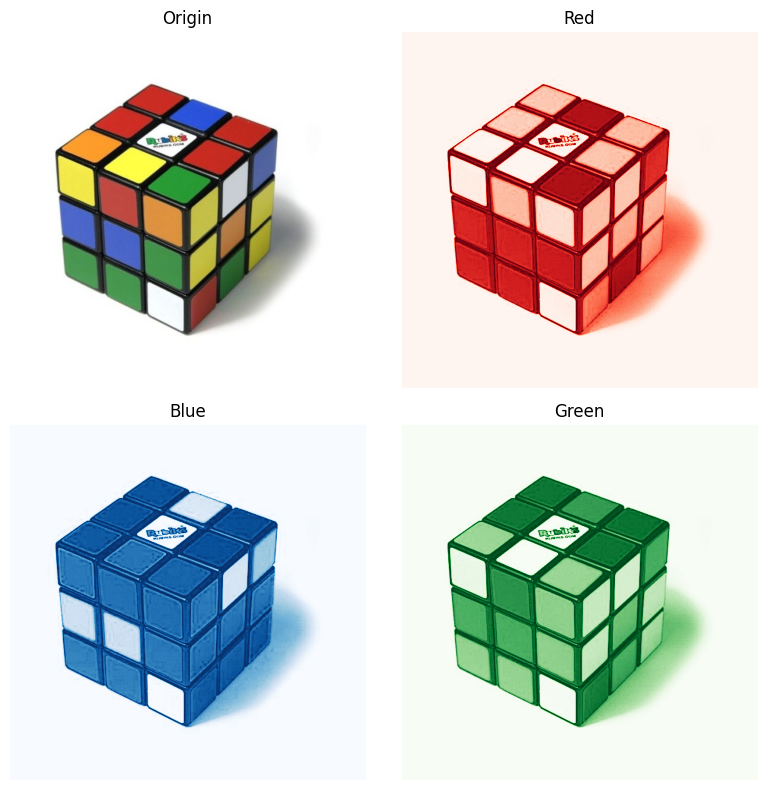

In [298]:
import cv2

import random as rng
from scipy import ndimage as ndi

input_image = cv2.imread('images/square6.jpg')
black_back_image = 255 - input_image

blue, green, red = cv2.split(black_back_image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)


plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Origin')
plt.axis('off')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

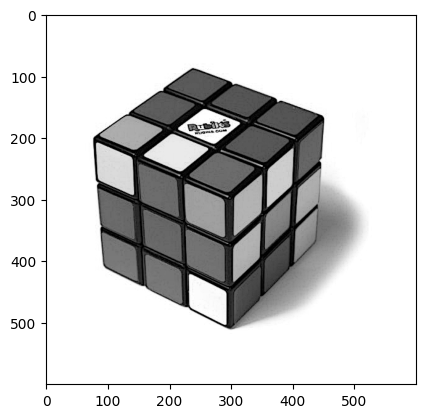

In [299]:
# Unione dei colori
from skimage.morphology import square
from skimage import filters

HP_gray_image = 255 - cv2.cvtColor(cv2.merge([blue, green, red],), cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
plt.imshow(HP_gray_image,cmap="gray")

In [300]:
adaptive_gaussian = cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 7) 

In [301]:
resized = cv2.resize(adaptive_gaussian, (300, 300), interpolation = cv2.INTER_AREA)

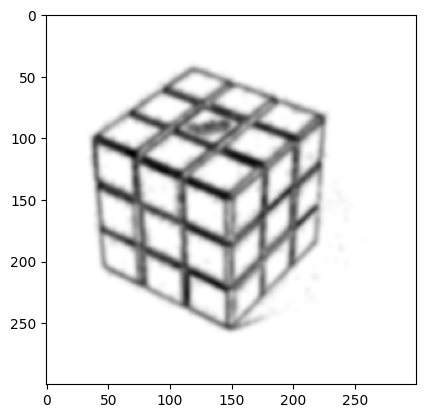

In [302]:
smooth = filters.gaussian(resized, sigma=2)
plt.imshow(smooth,cmap="gray")

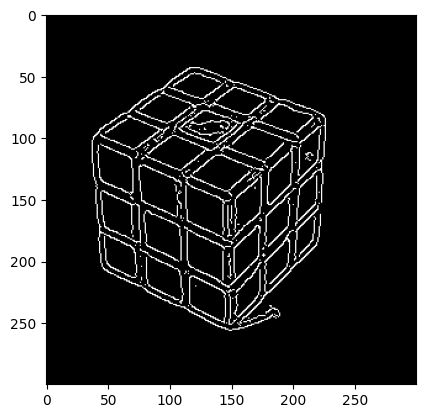

In [303]:
smooth *= 255/smooth.max() 
smooth = np.array(smooth, np.uint8)


lower = 10
upper = lower*3
canny = cv2.Canny(smooth,lower,upper)
plt.imshow(canny,cmap="gray")

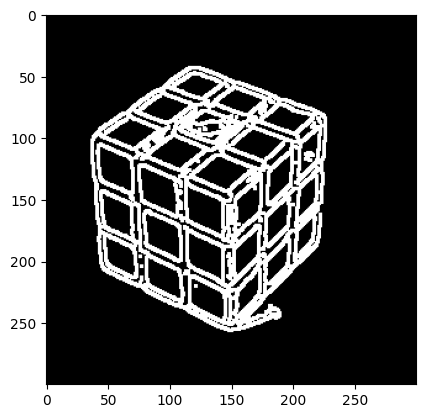

In [304]:
kernel = np.ones((3,3),np.uint8)
dilatated = cv2.dilate(canny,kernel,iterations = 1)
plt.imshow(dilatated,cmap="gray")

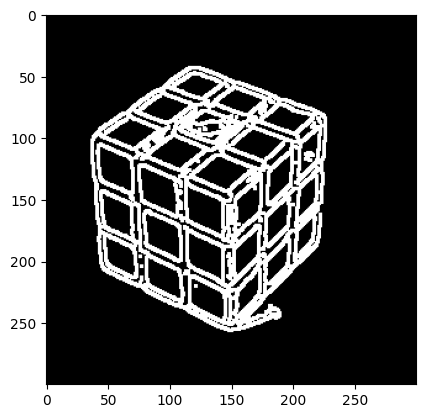

In [305]:
thickness = 50

cv2.line(dilatated, (0,0), (0,300), (0,0,0), thickness)
cv2.line(dilatated, (0,300), (300,300), (0,0,0), thickness)
cv2.line(dilatated, (300,300), (300,0), (0,0,0), thickness)
cv2.line(dilatated, (300,0), (0,0), (0,0,0), thickness)

plt.imshow(dilatated,cmap="gray")

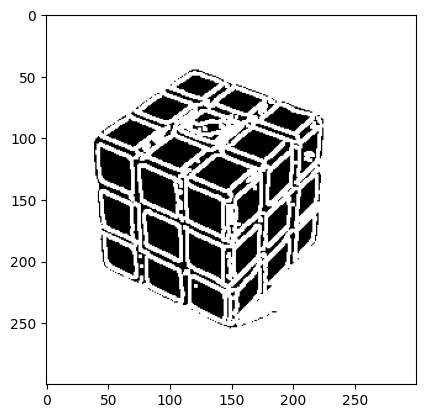

In [306]:
seed_point = (0, 0)
new_color = (255,255,255)

cv2.floodFill(dilatated, None, seed_point, new_color)

plt.imshow(dilatated,cmap="gray")

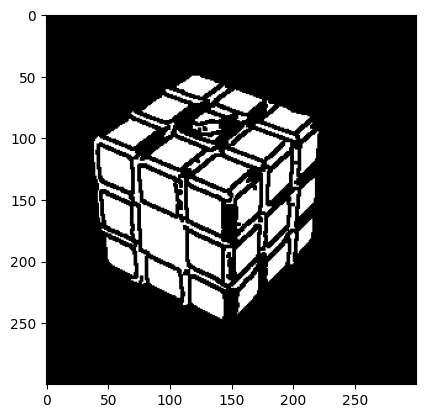

In [307]:
contours, _ = cv2.findContours(255-dilatated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 10
filtered_image = np.zeros_like(dilatated)
for contour in contours:
    area = cv2.contourArea(contour)
    if area >= min_area:
        cv2.drawContours(filtered_image, [contour], -1, 255, thickness=cv2.FILLED)

plt.imshow(filtered_image,cmap="gray")

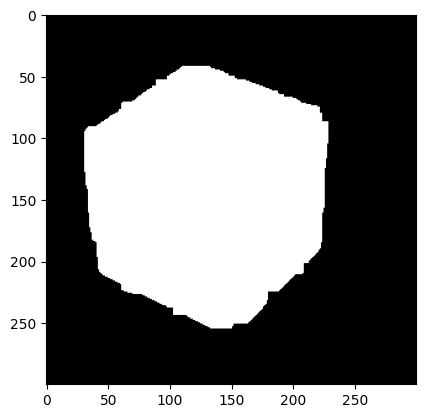

In [308]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.dilate(filtered_image,kernel,iterations = 4)
plt.imshow(erosion,cmap="gray")

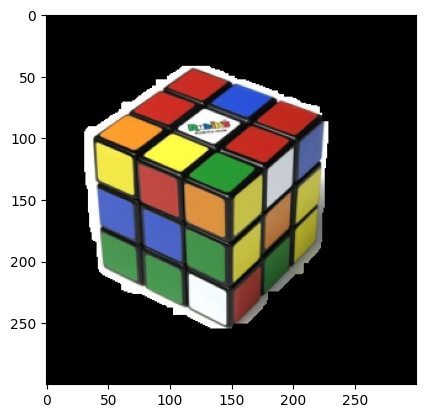

In [309]:
tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
result_image = cv2.bitwise_and(tmp, tmp, mask=erosion)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

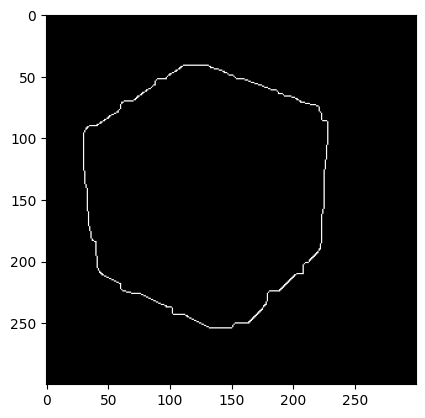

In [310]:
edges = cv2.Canny(erosion, 50, 150)
plt.imshow(edges,cmap="gray")

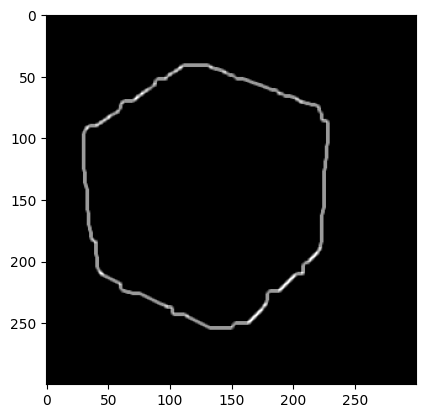

In [311]:
mean_kernel = np.full((3, 3), 1/9)
edges = ndi.correlate(edges, mean_kernel)
plt.imshow(edges,cmap="gray")

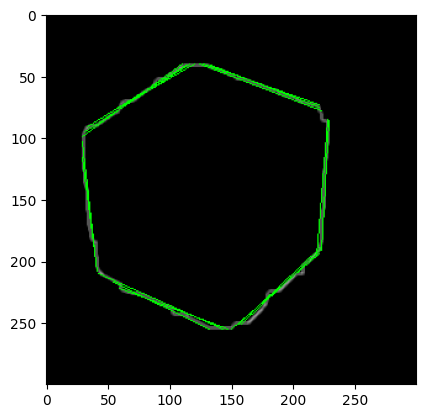

In [312]:

lines = cv2.HoughLinesP(edges, 7, np.pi/120, threshold=30, minLineLength=60, maxLineGap=30)

# Disegna le linee sull'immagine originale per visualizzazione
image_with_lines = image_with_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 1)
plt.imshow(image_with_lines,cmap="gray")

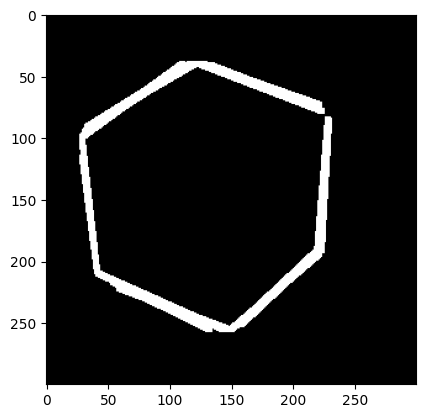

In [313]:
void = np.zeros_like(erosion)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(void, (x1, y1), (x2, y2), 255, 1)
void = cv2.dilate(void,kernel,iterations = 1)
plt.imshow(void,cmap="gray")

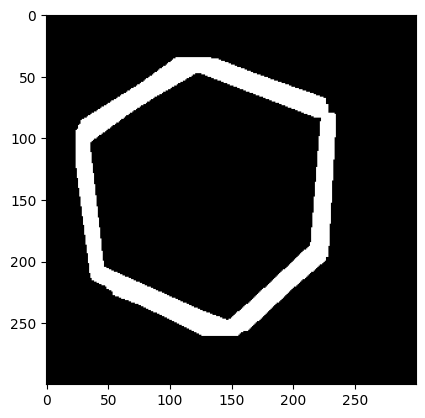

In [314]:
kernel = np.ones((7,7),np.uint8)
void = cv2.dilate(void,kernel,iterations = 1)
plt.imshow(void,cmap="gray")

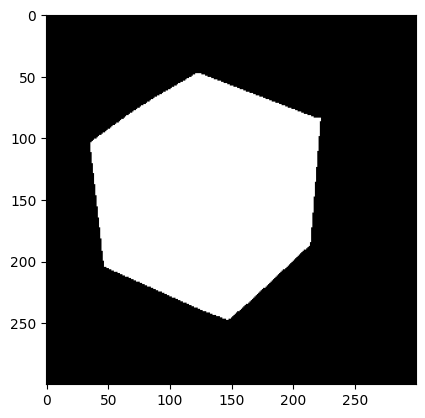

In [315]:
seed_point = (0, 0)
new_color = (255,255,255)

cv2.floodFill(void, None, seed_point, new_color)
void = 255 - void
plt.imshow(void,cmap="gray")

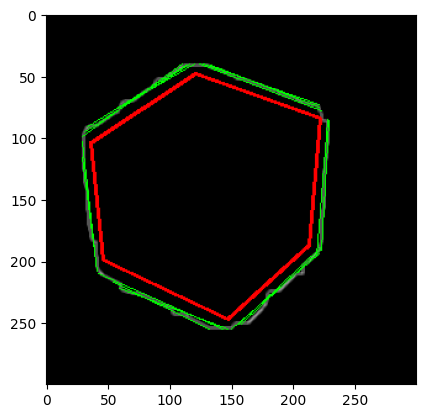

In [316]:
contours, _ = cv2.findContours(void, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


epsilon = 0.02 * cv2.arcLength(contours[0], True)
approx_polygon = cv2.approxPolyDP(contours[0], epsilon, True)

tmp = cv2.cvtColor(np.zeros_like(erosion),cv2.COLOR_GRAY2RGB)
cv2.drawContours(image_with_lines, [approx_polygon], -1, (0,0,255), thickness = 2)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))

Lunghezza dei lati verticali esterni dell'esagono: 99
Vertice più basso dell'esagono: [147 247]


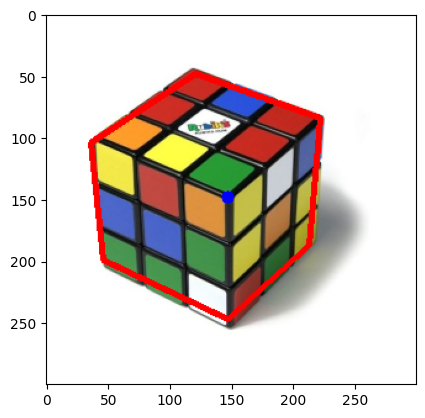

In [317]:
sorted_vertices = sorted(approx_polygon, key=lambda point: point[0][1])

tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
cv2.drawContours(tmp, [approx_polygon], -1, (0, 0, 255), thickness = 3)
y_top_0 = int((sorted_vertices[2][0][0] + sorted_vertices[1][0][0])/2)
y_top_1 = int((sorted_vertices[2][0][1] + sorted_vertices[1][0][1])/2)

y_bottom_0 = int((sorted_vertices[-2][0][0] + sorted_vertices[-3][0][0])/2)
y_bottom_1 = int((sorted_vertices[-2][0][1] + sorted_vertices[-3][0][1])/2)

vertical_side_length = y_bottom_1 - y_top_1
print(f"Lunghezza dei lati verticali esterni dell'esagono: {vertical_side_length}")

lowest_vertex = sorted_vertices[-1][0]
print(f"Vertice più basso dell'esagono: {lowest_vertex}")

center = (lowest_vertex[0], lowest_vertex[1] - int(vertical_side_length))

cv2.circle(tmp, center, 5, 255, thickness=cv2.FILLED)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

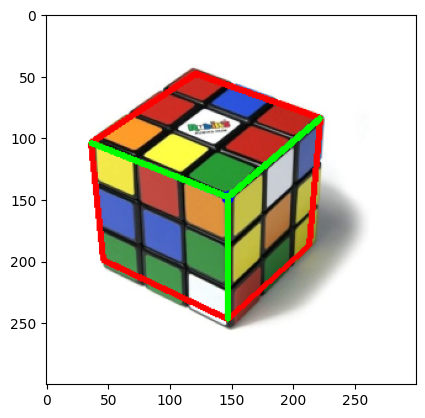

In [318]:
cv2.line(tmp, lowest_vertex, center, (0, 255, 0), thickness = 3)
cv2.line(tmp, sorted_vertices[1][0], center, (0, 255, 0), thickness = 3)
cv2.line(tmp, sorted_vertices[2][0], center, (0, 255, 0), thickness = 3)

plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

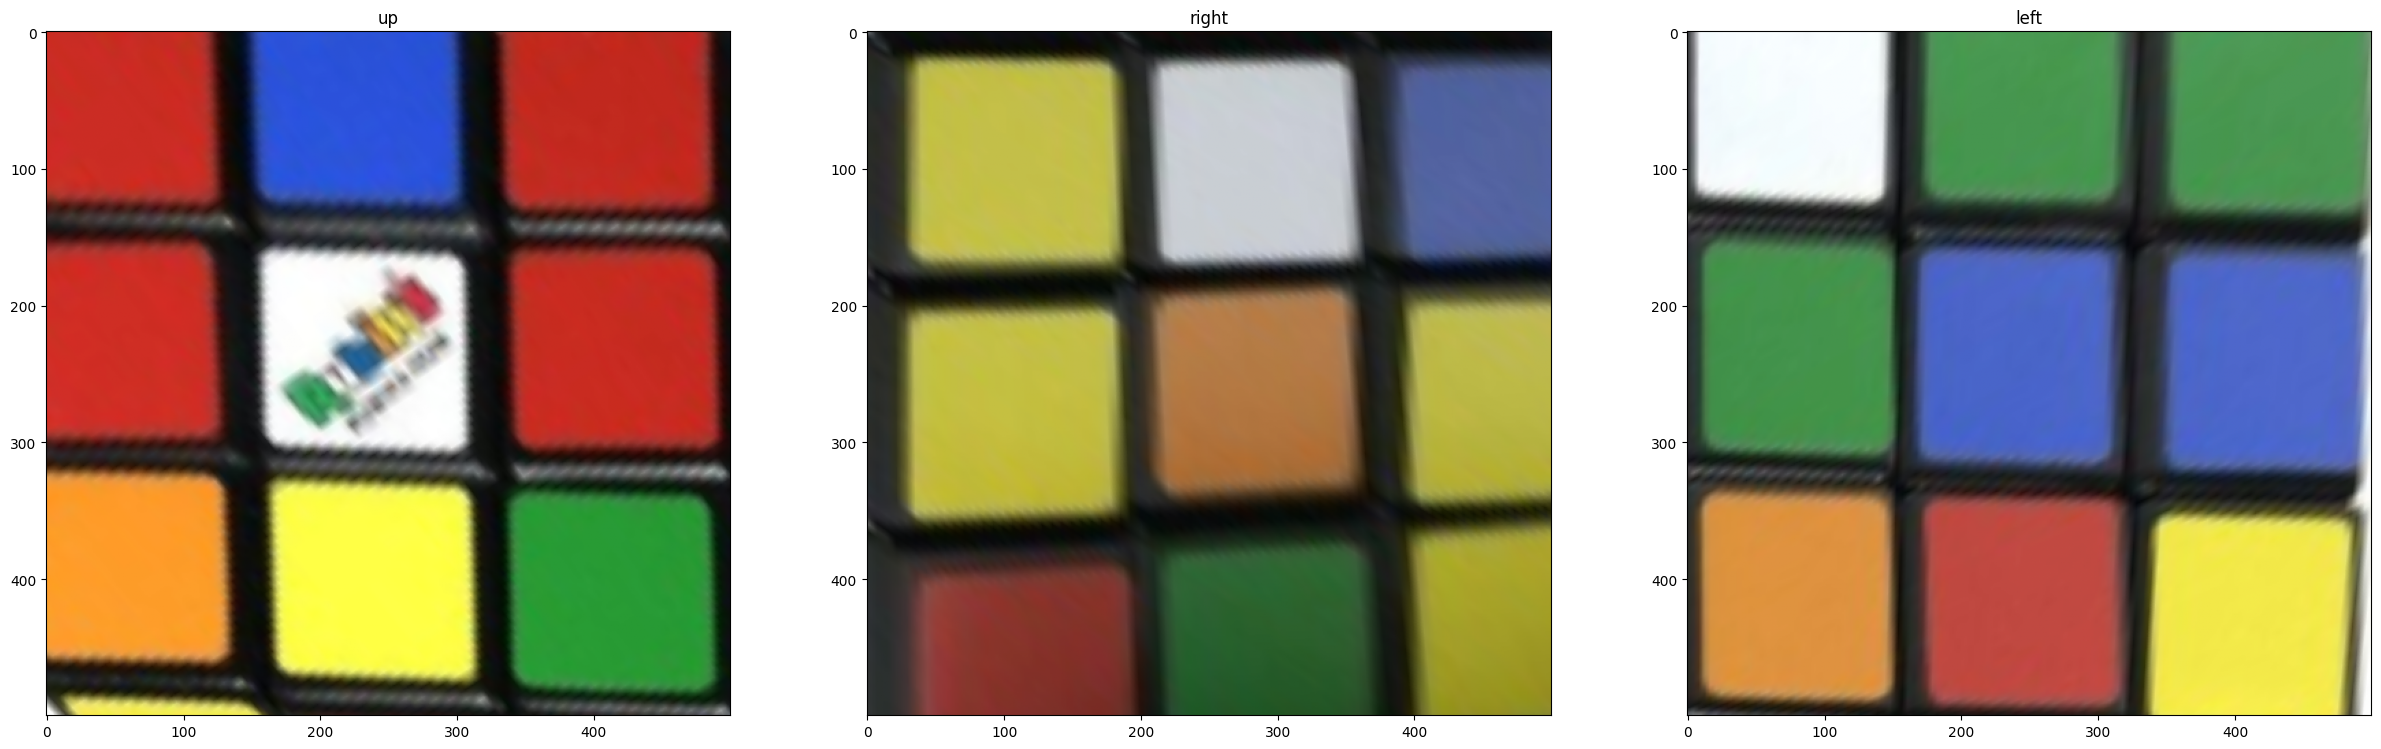

In [319]:
dst_square_size = 500
tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
dst_coordinates = np.array([[0, 0], [dst_square_size - 1, 0], [dst_square_size - 1, dst_square_size - 1], [0, dst_square_size - 1]], dtype=np.float32)

coordinates = np.array([sorted_vertices[0][0], sorted_vertices[1][0], center, sorted_vertices[2][0]], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image1 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

DX1=DX2=SX1=SX2=0
if(sorted_vertices[1][0][0] > sorted_vertices[2][0][0]):
    DX1 = sorted_vertices[1][0]
    SX1 = sorted_vertices[2][0]
else:
    DX1 = sorted_vertices[2][0]
    SX1 = sorted_vertices[1][0]
if(sorted_vertices[3][0][0] > sorted_vertices[4][0][0]):
    DX2 = sorted_vertices[3][0]
    SX2 = sorted_vertices[4][0]
else:
    DX2 = sorted_vertices[4][0]
    SX2 = sorted_vertices[3][0]

coordinates = np.array([ center, DX1, DX2, lowest_vertex], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image2 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

coordinates = np.array([ lowest_vertex, SX2, SX1, center], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image3 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

imshow_all(cv2.cvtColor(result_image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image2, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image3, cv2.COLOR_BGR2RGB),titles=["up","right","left"])